# 'Buy or not' classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split

In [2]:
dataset = np.load('./dataset.npy')

In [3]:
target = np.load('./target.npy')

In [4]:
dataset.shape

(9249729, 10)

In [5]:
target.shape

(9249729,)

Splitting dataset into train and test sets in ratio 8:2. 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset, target, test_size=0.2, stratify=target)

Random forest has a tendency to overfit. There are two major groups of parameters to control its generalization ability: 
- tree's depth restrictions;
- number of trees in forest.

While our empirical results suggest that number of trees in forest has almost no effect on resulting score, tree's depth restrictions are the only parameters left to be selected.

Following the article, I've chosen minimum number of samples that have to be present within an internal node in a tree along with unrestricted maximal depth. Thus search over only one number has to be performed.


In [7]:
min_splits = np.array([100, 200, 300, 500, 750, 1500])

for min_split in min_splits:

    rf = RandomForestClassifier(n_estimators=200, max_depth=None, 
                                min_samples_split=min_split, class_weight='balanced',
                                n_jobs=-1)
    rf.fit(X_train, y_train)
    y_proba = rf.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, y_proba[:,1])
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:, 1])
    pr_auc = auc(recall, precision, reorder=True)
    
    print 'min_split=%d, ROC AUC=%.4f, PR AUC=%.4f' %(min_split, roc_auc, pr_auc)

min_split=100, ROC AUC=0.8684, PR AUC=0.3573
min_split=200, ROC AUC=0.8729, PR AUC=0.3653
min_split=300, ROC AUC=0.8745, PR AUC=0.3671
min_split=500, ROC AUC=0.8758, PR AUC=0.3681
min_split=750, ROC AUC=0.8763, PR AUC=0.3664
min_split=1500, ROC AUC=0.8763, PR AUC=0.3616


As one can see, as `min_split` reaches the value of 500 and goes up to 2500, there are no changes in ROC AUC. However, the value of Precision-Recall AUC has maximum around `min_split = 500`. This clearly leaves us with the optimal choice of `min_split` of 500. 

In [8]:
optimal_min_sample_split = 500
rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=optimal_min_sample_split,
                           n_jobs=-1)
rf.fit(X_train, y_train)
y_proba = rf.predict_proba(X_test)

### Classifier evaluation

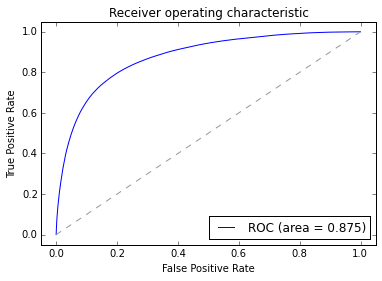

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.3f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

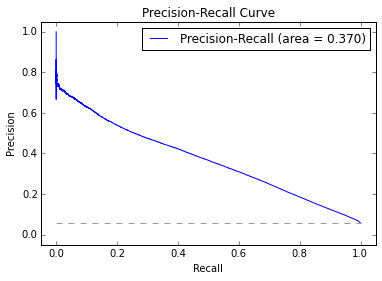

In [10]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:, 1])

buy_fraction = np.mean(y_test)

pr_auc = auc(recall, precision, reorder=True)
plt.plot(recall, precision, lw=1, label='Precision-Recall (area = %0.3f)' % (pr_auc))
plt.plot([0, 1], [buy_fraction, buy_fraction], '--', color=(0.6, 0.6, 0.6))
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


In order to compute accuracy, precision and recall one needs to choose decision rule, i.e. threshold for the predicted probabilities. Since there is no predefined preferences, i.e. losses for types I and II errors, the F1-measure is selected as criterion for selecting optimum threshold.

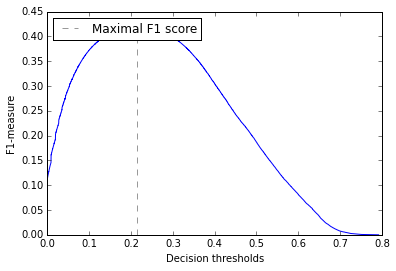

In [11]:
F1 = 2 * (precision * recall) / (precision + recall)

optimal_threshold_i = np.where(F1 == np.max(F1))[0][0]
optimal_threshold = thresholds[optimal_threshold_i]

plt.plot(thresholds, F1[1:])
plt.plot([optimal_threshold, optimal_threshold], [np.min(F1), np.max(F1)], '--', color=(0.6, 0.6, 0.6),
         label = 'Maximal F1 score')
plt.xlabel('Decision thresholds')
plt.ylabel('F1-measure')
plt.legend(loc = 'upper left')

And the requested metrics for the selected decision rule are:

In [12]:
final_precision = precision_score(y_test, y_proba[:, 1] > optimal_threshold)
final_recall = recall_score(y_test, y_proba[:, 1] > optimal_threshold)

accuracy = np.mean(y_test == (y_proba[:, 1] > optimal_threshold))

print 'Decision threshold: %.2f' % optimal_threshold
print 'Precision: %.2f' % final_precision
print 'Recall: %.2f' % final_recall
print 'Accuracy: %.2f' % accuracy

Decision threshold: 0.21
Precision: 0.37
Recall: 0.50
Accuracy: 0.93
